In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')

In [14]:
ios_moor = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/IOS_ctd_moor.p')
ios_prof = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/IOS_ctd_prof.p')

In [16]:
ios_moor.columns

Index(['longitude (degrees_east)', 'latitude (degrees_north)',
       'sea_water_pressure (dbar)', 'depth (m)',
       'sea_water_temperature (degC)', 'sea_water_practical_salinity (PSS-78)',
       'DOXYZZ01 (mL/L)', 'datetime'],
      dtype='object')

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:558: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return matplotlib.axes.Axes.draw(self, renderer=renderer, **kwargs)
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:530: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return matplotlib.axes.Axes.get_tightbbox(
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


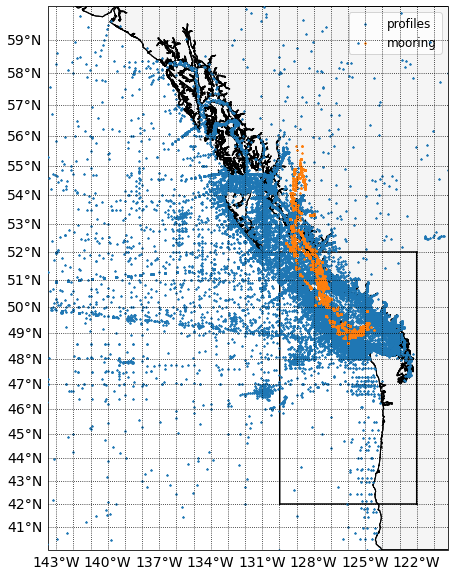

In [59]:
# Increase font size
plt.rcParams['font.size'] = 14

# Make plot area
xlim, ylim = [-143.5, -120.2], [40, 60]
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('full', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', zorder=4))

# Add gridlines
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs, zorder=8)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False

# Draw box
ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], 'k-', zorder=6, transform=crs.PlateCarree())

# add points
ax.scatter(ios_prof['longitude (degrees_east)'], ios_prof['latitude (degrees_north)'], s=3, marker='*', label='profiles',transform=crs.PlateCarree(),zorder=7)
ax.scatter(ios_moor['longitude (degrees_east)'], ios_moor['latitude (degrees_north)'], s=3, marker='*', label='mooring',transform=crs.PlateCarree(),zorder=7)
ax.legend(fontsize=12)

In [67]:
# very quick qa/qc
# remove all unreasonable values
ios_prof.loc[ios_prof['sea_water_temperature (degC)'] > 40, 'sea_water_temperature (degC)'] = pd.NA
ios_prof.loc[ios_prof['sea_water_temperature (degC)'] <-3, 'sea_water_temperature (degC)'] = pd.NA

ios_prof.loc[ios_prof['sea_water_practical_salinity (PSS-78)'] > 50, 'sea_water_practical_salinity (PSS-78)'] = pd.NA
ios_prof.loc[ios_prof['sea_water_practical_salinity (PSS-78)'] < 0, 'sea_water_practical_salinity (PSS-78)'] = pd.NA

ios_moor.loc[ios_moor['sea_water_temperature (degC)'] > 40, 'sea_water_temperature (degC)'] = pd.NA
ios_moor.loc[ios_moor['sea_water_temperature (degC)'] <-3, 'sea_water_temperature (degC)'] = pd.NA

ios_moor.loc[ios_moor['sea_water_practical_salinity (PSS-78)'] > 50, 'sea_water_practical_salinity (PSS-78)'] = pd.NA
ios_moor.loc[ios_moor['sea_water_practical_salinity (PSS-78)'] < 0, 'sea_water_practical_salinity (PSS-78)'] = pd.NA




In [6]:
ooi_chl = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/OOI_chlorophyll.p').drop(['z (Altitude, m)'],axis=1)
ooi_co2 = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/OOI_co2.p').drop(['z (Altitude, m)'],axis=1)
ooi_oxy = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/OOI_oxygen.p').drop(['z (Altitude, m)'],axis=1)
ooi_nit = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/OOI_nitrate.p').drop(['z (Altitude, m)'],axis=1)

In [12]:
print(len(ooi_chl))
print(len(ooi_co2))
print(len(ooi_oxy))
print(len(ooi_nit))


953302
766819
1631564
496933


/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


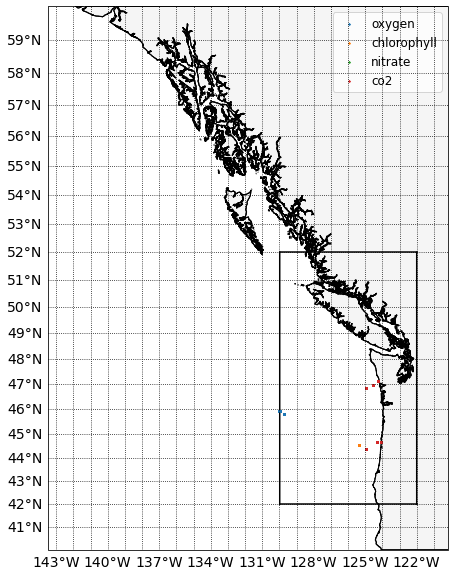

In [11]:
# Increase font size
plt.rcParams['font.size'] = 14

# Make plot area
xlim, ylim = [-143.5, -120.2], [40, 60]
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('full', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', zorder=4))

# Add gridlines
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs, zorder=8)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False

# Draw box
ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], 'k-', zorder=6, transform=crs.PlateCarree())

# add points  
ax.scatter(ooi_oxy['longitude (degrees_east)'], ooi_oxy['latitude (degrees_north)'], s=10, marker='*', label='oxygen',transform=crs.PlateCarree(),zorder=7)
ax.scatter(ooi_chl['longitude (degrees_east)'], ooi_chl['latitude (degrees_north)'], s=10, marker='*', label='chlorophyll',transform=crs.PlateCarree(),zorder=7)
ax.scatter(ooi_nit['longitude (degrees_east)'], ooi_nit['latitude (degrees_north)'], s=10, marker='*', label='nitrate',transform=crs.PlateCarree(),zorder=7)
ax.scatter(ooi_co2['longitude (degrees_east)'], ooi_co2['latitude (degrees_north)'], s=10, marker='*', label='co2',transform=crs.PlateCarree(),zorder=7)

ax.legend(fontsize=12)

In [69]:
onc = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/ONC.p')

In [70]:
onc

,salinity,Temperature,Pressure,longitude,latitude,depth
time,,,,,,
